# A tour of fieldmaps

Over the years, siemens has changed how it writes fieldmaps. In the most recent years they, like most other manufacturers, write out magnitude images and a "phasediff" image. Prior to this they would write out both phase images separately, relying on the user to calculate the phase difference. In the BIDS 1.0 spec, the fieldmap with a `phase1` and `phase2` image are described in section 8.9.2. 

FSL's `PRELUDE` and `FUGUE` can be used to correct for susceptibility-related displacements in the BOLD signal. This is very straightforward when a phasediff is available, and `fsl_prepare_fieldmap` handles this directly. `PRELUDE` unwraps the phasediff.

The `PRELUDE` to `FUGUE` pipeline also works if a phasediff is calculated from the `phase1` and `phase2` images. The most intuitive approach to calculating a phasediff is to simply subtract the `phase2` values from the `phase1` values in each voxel. Phase wrapping *should* be corrected by `PRELUDE`. However, subtracting complex numbers doesn't work in all cases and can result in wrapping that `PRELUDE` fails to handle.

## Nuances of phasediff calculation

Consider two complex numbers $z_1 = R_1e^{i\phi_1}$ and $z_2=R_2e^{i\phi_2}$. We use the $\arctan$ function to calculate the phasediff. For example

$$\arctan(z_1) = \phi_1$$

We run into problems when wrapping occurs. While $\arctan\left(R_1e^{i\Delta}\right) = \Delta$, it is also true that $\arctan\left(R_1e^{i(2\pi + \Delta)}\right) = \Delta$. If we have two complex numbers $z_2=R_2e^{i(2\pi+\Delta)}$ and $z_1=R_1e^{i(2\pi-\Delta)}$. If we directly subtract the arctans of these two values, we arrive at an incorrect result:

$$\arctan\left(z_2\right) - \arctan\left(z_1\right) = 2\Delta - 2\pi$$

Alternatively we can calculate the phasediff by taking the arctan of the ratio of the complex numbers. For example 

$$\begin{align}
\arctan\left(\frac{z_2}{z_1}\right) & = \arctan\left[\frac{R_2e^{i(2\pi+\Delta)}}{R_1e^{i(2\pi-\Delta)}}\right] \\
& = \arctan\left[\frac{R_2}{R_1}e^{i\left[(2\pi + \Delta)-(2\pi - \Delta) \right]} \right] \\
& = \arctan\left[\frac{R_2}{R_1}e^{i2\Delta}\right] \\
& = 2\Delta
\end{align}
$$

Which is the correct answer. In our patch to `FMRIPREP` we use Euler's identity and then $\arctan$ to calculate the phasediff. We collected a bunch of data to show that this approach produces the most similar values to those that are calculated by the scanner when it writes out phasediff images.

## Experimental data

We scanned three different versions of siemens GRE fieldmap sequences that were collected over the past 5 years.  We also collected a reverse phase-encoding EPI for PEPOLAR SDC. The same voxel size was used and the subject was an expert who moved very little. These can be downloaded from [open neuro](https://openneuro.org/datasets/ds001600).

### B0map v1

This is the first GRE sequence collected for the Philadelphia Neurodevelopmental Cohort (PNC). This produces `phase1` and `phase2` images, but uses a bipolar readout. This is problematic because it requires additional corrections before a phasediff can be calculated. Since `ReadoutMode` is not a field in BIDS there is no way to detect if a bipolar readout mode was used. 

### B0map v2

This is similar to `v1`, but uses monopolar readout. There is no special correction that needs to be done to these values, they can go straight into the phasediff equation.

### B0map v4

We skipped right over `v3` and got scanner-generated `phasediff` images. One tricky thing about this sequence is that `dcm2niix` does not recognize that it's a phasediff. I had to go into the json file and manually add `"EchoTime1"` and `"EchoTime2"`.

### AP/PA EPI references

We collected 5 TRs of resting state data in both the AP and PA phase encoding directions. Copies were included in both the `fmap` directory and the `func` directory. The resting state with the same phase encoding direction as the GRE fieldmaps was duplicated with an (eg) `_acq-v1_` tag to identify which fieldmap will list it in `"IntendedFor"`.

## Analysis

We want to show that we're calculating phasediffs correctly.

In [1]:
# Load the ipython display and image module
from IPython.display import Image
from IPython.display import display
from IPython.display import SVG

v1_phase1_nii = "example_fieldmaps/sub-1/fmap/sub-1_acq-v1_phase1.nii.gz"
v1_phase2_nii = "example_fieldmaps/sub-1/fmap/sub-1_acq-v1_phase2.nii.gz"
v2_phase1_nii = "example_fieldmaps/sub-1/fmap/sub-1_acq-v2_phase1.nii.gz"
v2_phase2_nii = "example_fieldmaps/sub-1/fmap/sub-1_acq-v2_phase2.nii.gz"
v4_phasediff_nii = "example_fieldmaps/sub-1/fmap/sub-1_acq-v4_phasediff.nii.gz"
brainmask = "real_mask.nii.gz"

Here are some plots that show what values are in each image

Populating the interactive namespace from numpy and matplotlib


/Users/mcieslak/miniconda3/envs/py3k/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


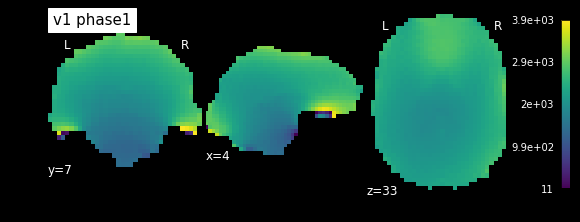

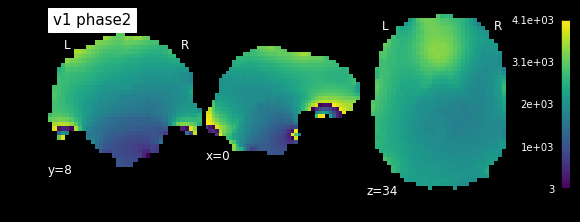

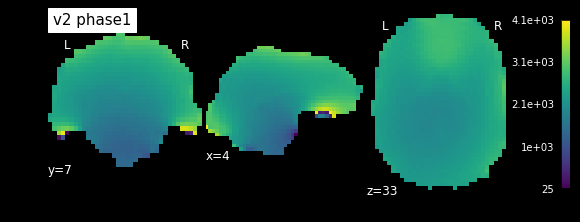

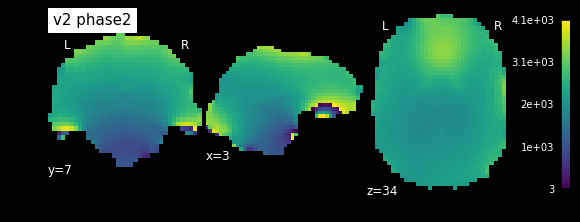

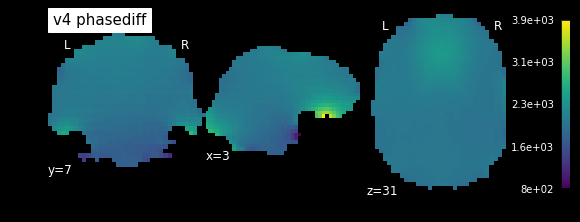

In [2]:
%pylab inline
from nilearn.plotting import plot_img
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb

brain_mask = nb.load(brainmask).get_data() < 1

def get_brain(fname):
    img = nb.load(fname)
    image = img.get_fdata()
    image[brain_mask] = 0
    return nb.Nifti1Image(image, img.affine, img.header)

v1_phase1 = get_brain(v1_phase1_nii)
v1_phase2 = get_brain(v1_phase2_nii)
v2_phase1 = get_brain(v2_phase1_nii)
v2_phase2 = get_brain(v2_phase2_nii)
v4_phasediff = get_brain(v4_phasediff_nii)


plot_img(v1_phase1, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v1 phase1")
plot_img(v1_phase2, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v1 phase2")

plot_img(v2_phase1, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v2 phase1")
plot_img(v2_phase2, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v2 phase2")

plot_img(v4_phasediff, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v4 phasediff");

Calculate some subtractions

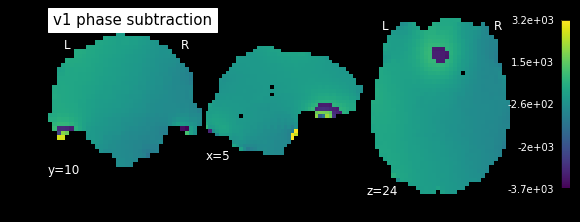

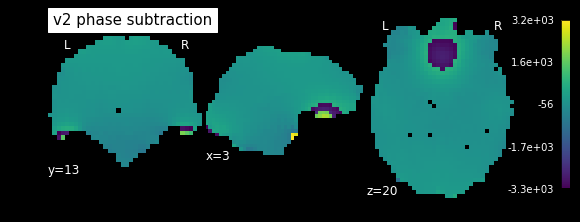

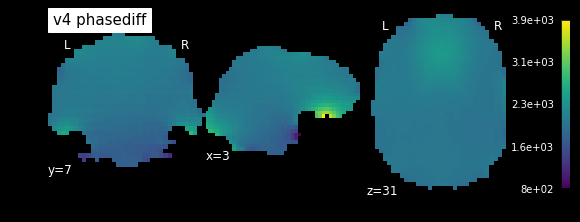

In [3]:
def subtract_phases(phase1, phase2):
    return nb.Nifti1Image(phase2.get_data() - phase1.get_data(), phase1.affine, phase1.header)

v1_phase_subtraction = subtract_phases(v1_phase1, v1_phase2)
plot_img(v1_phase_subtraction, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v1 phase subtraction")

v2_phase_subtraction = subtract_phases(v2_phase1, v2_phase2)
plot_img(v2_phase_subtraction, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v2 phase subtraction")

plot_img(v4_phasediff, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v4 phasediff")

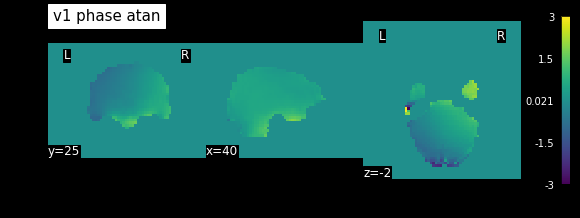

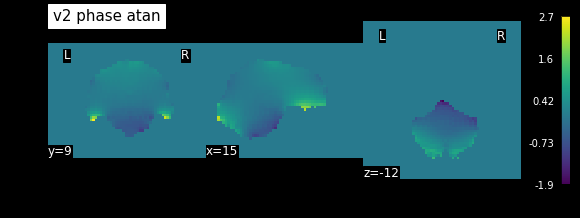

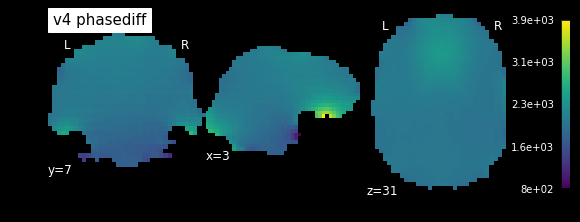

In [4]:
def rescale_image(img):
    mask = img > 0
    imax = img.max()
    imin = img.min()
    max_check = imax - 4096
    if np.abs(max_check) > 10 or np.abs(imin) > 10:
        print("Phase image may be scaled incorrectly: check results")
    return mask * (img / 2048 * np.pi - np.pi)
 

def atan_images(phase1_img, phase2_img):
    
    # Calculate fieldmaps
    rad0 = rescale_image(phase1_img.get_fdata())
    rad1 = rescale_image(phase2_img.get_fdata())
    a = np.cos(rad0)
    b = np.sin(rad0)
    c = np.cos(rad1)
    d = np.sin(rad1)
    fmap = -np.arctan2(b * c - a * d, a * c + b * d)
    return nb.Nifti1Image(fmap, phase1_img.affine)

v1_phase_atan = atan_images(v1_phase2, v1_phase1)
plot_img(v1_phase_atan, colorbar=True, draw_cross=False,
         black_bg=True, title="v1 phase atan")
v2_phase_atan = atan_images(v2_phase1, v2_phase2)
plot_img(v2_phase_atan, colorbar=True, draw_cross=False,
         black_bg=True, title="v2 phase atan")
plot_img(v4_phasediff, colorbar=True, threshold="auto", draw_cross=False,
         black_bg=True, title="v4 phasediff")

The `v1` fieldmaps have an issue where the measurement is automatically increasing on the `i` axis. I'm not sure how this axis is picked (the `j` axis is the PE direction). The atan method doesn't have any banding or empty voxels. `v2` looks like a scaled version of the phasediff image.

### Consequences for SDC

Each of these was sent through `FMRIPREP`. The `phase1`, `phase2` images were processed with the code from our PR. Below are plotted the results. First, the AP/PA was used for PEB SDC. Next, the code from the PR was used on `v1` and `v2` fieldmaps. Finally, the original `FMRIPREP` code was used for the `v4` phasediff. 

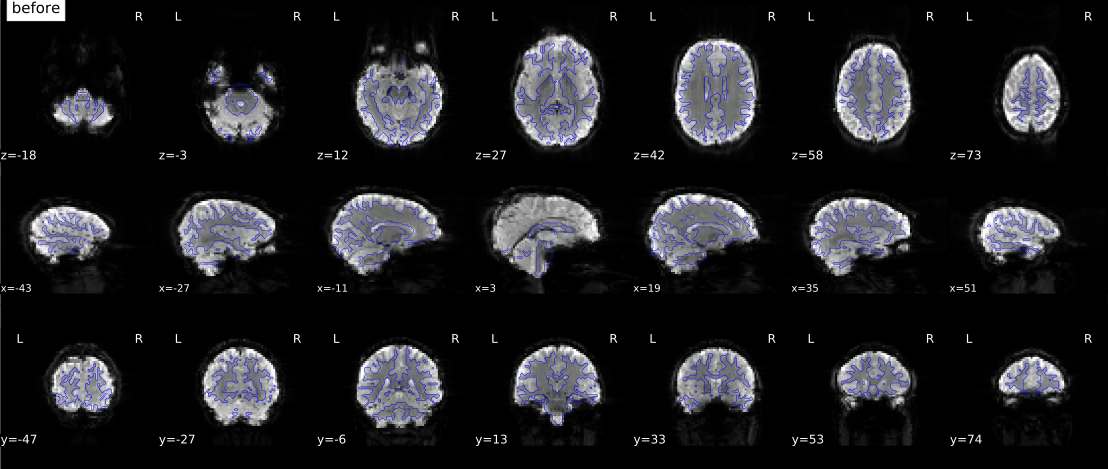

In [5]:
display(SVG("figures/sub-1_task-rest_acq-PA_sdc_epi.svg"))

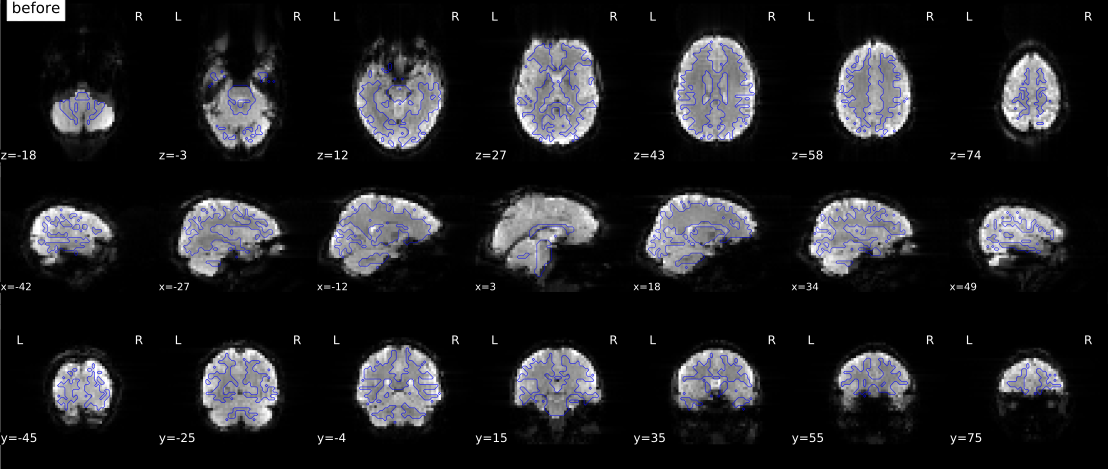

In [6]:
display(SVG("figures/sub-1_task-rest_acq-v1_sdc_phase.svg"))

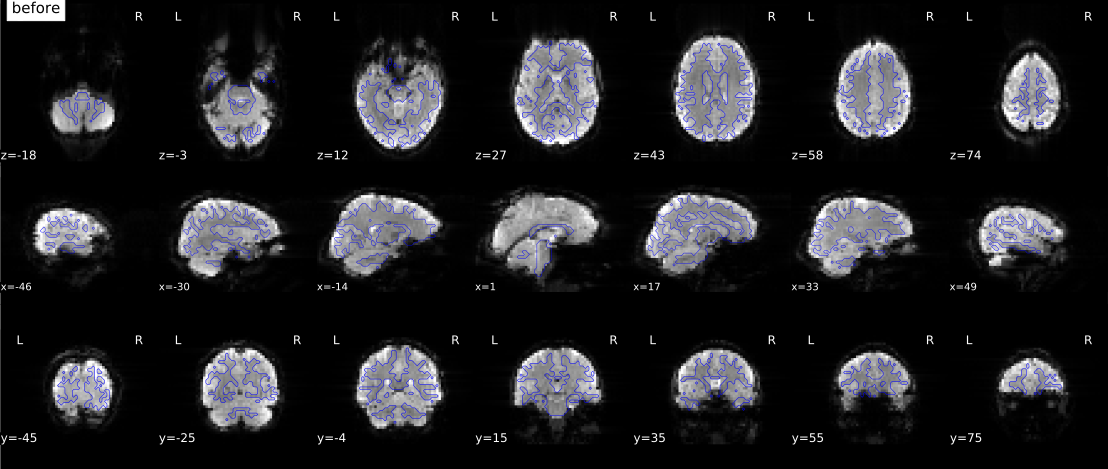

In [7]:
display(SVG("figures/sub-1_task-rest_acq-v2_sdc_phase.svg"))

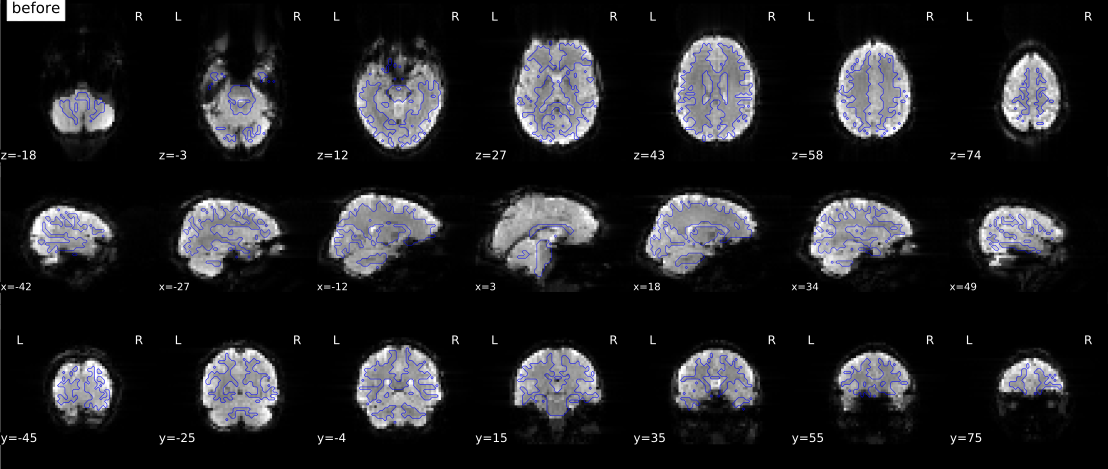

In [8]:
display(SVG("figures/sub-1_task-rest_acq-v4_sdc_phasediff.svg"))

## Results

`v2` looks just like the currently-supported `phasediff` and `epi` correction methods. There is an additional correction needed for the bipolar readout used in `v1`. 